# Analyzing images with Azure Content Safety

## Use-case: images defect detection
### Part 1: Azure Content Safety analysis on the images

Six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., **rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc)**. The database includes grayscale images.

> https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

<img src="neu.png">

In [1]:
import csv
import glob
import ipyplot
import os
import pandas as pd
import sys

from azure.ai.contentsafety import ContentSafetyClient
from azure.ai.contentsafety.models import AnalyzeImageOptions, ImageData, ImageCategory
from azure.core.credentials import AzureKeyCredential
from datetime import datetime
from dotenv import load_dotenv
from PIL import Image

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-22 13:26:01


In [4]:
load_dotenv("azure.env")

azure_content_safety_endpoint = os.getenv("azure_content_safety_endpoint")
azure_content_safety_key = os.getenv("azure_content_safety_key")

## 1 Helper

In [5]:
def count_image_files(mydir):
    """
    Counts and prints the number of image files in each subdirectory of the given directory.

    Args:
        path (str): The path to the directory to search for image files.
    """
    image_extensions = {'.jpg', '.jpeg', '.png', '.webp'}
    nb_images = 0

    for root, dirs, files in os.walk(mydir):
        dirs[:] = [d for d in dirs if d != '.ipynb_checkpoints']
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            num_image_files = len([
                f for f in os.listdir(subdir_path)
                if os.path.isfile(os.path.join(subdir_path, f))
                and os.path.splitext(f)[1].lower() in image_extensions
            ])
            print(f"{subdir_path} | Number of image files = {num_image_files}")
            nb_images += num_image_files

    return nb_images

In [6]:
def display_image(image_file):
    """
    Display an image file.

    This function checks if the specified image file exists. 
    If the file exists, it opens and displays the image.
    If the file does not exist, it prints an error message.

    Parameters:
    image_file (str): The path to the image file to be displayed.
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(f"Image file to classify: {image_file}")
        img = Image.open(image_file)
        display(img)

In [7]:
def analyzing_image(image_file):
    """
    Analyzes an image file for content safety categories and returns the results.

    This function uses the Azure Content Safety Client to analyze an image file for various content safety categories,
    including hate, self-harm, sexual, and violence. The results are returned as a dictionary with the severity levels
    for each category.

    Parameters:
    image_file (str): The path to the image file to be analyzed.

    Returns:
    dict: A dictionary containing the analysis results for the image. The keys are:
          - "image_file": The path to the image file.
          - "hate_severity": The severity level of hate content, or None if not present.
          - "self_harm_severity": The severity level of self-harm content, or None if not present.
          - "sexual_severity": The severity level of sexual content, or None if not present.
          - "violence_severity": The severity level of violence content, or None if not present.
    """   
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        # Reading file
        with open(image_file, "rb") as file:
            request = AnalyzeImageOptions(image=ImageData(content=file.read()))

        try:
            # Analyzing the file
            acs_client = ContentSafetyClient(
                azure_content_safety_endpoint, AzureKeyCredential(azure_content_safety_key))
            response = acs_client.analyze_image(request)

            # Get results
            hate_result = next(
                (item for item in response.categories_analysis if item.category == ImageCategory.HATE), None)
            self_harm_result = next(
                (item for item in response.categories_analysis if item.category == ImageCategory.SELF_HARM), None)
            sexual_result = next(
                (item for item in response.categories_analysis if item.category == ImageCategory.SEXUAL), None)
            violence_result = next(
                (item for item in response.categories_analysis if item.category == ImageCategory.VIOLENCE), None)

            # Saving results into a dict
            results = {
                "image_file": image_file,
                "hate_severity": hate_result.severity if hate_result else None,
                "self_harm_severity": self_harm_result.severity if self_harm_result else None,
                "sexual_severity": sexual_result.severity if sexual_result else None,
                "violence_severity": violence_result.severity if violence_result else None
            }

        except HttpResponseError as e:
            print("Analyze image failed.")
            if e.error:
                print(f"[Error]: {e.error.code}")
                print(f"[Error]: {e.error.message}")

        return results

In [8]:
def get_images_info(mydir):
    """
    Collects information about image files in a directory and its subdirectories.

    This function walks through the given directory and its subdirectories to find image files
    with extensions .png, .jpg, .jpeg, .gif, and .bmp. For each image file found, it collects
    the file path, file size in bytes, and image dimensions (width and height). The collected
    information is stored in a pandas DataFrame.

    Parameters:
    mydir (str): The directory path to search for image files.

    Returns:
    pd.DataFrame: A DataFrame containing the following columns:
        - 'Image_file': The file path of the image.
        - 'Size (bytes)': The size of the image file in bytes.
        - 'Width': The width of the image in pixels.
        - 'Height': The height of the image in pixels.
    """
    results = []

    for subdir, _, files in os.walk(mydir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_file = os.path.join(subdir, file)
                file_size = os.path.getsize(image_file)
                with Image.open(image_file) as img:
                    width, height = img.size
                results.append({'image_file': image_file, 'size_in_bytes': file_size, 'image_width': width, 'image_height': height})

    df = pd.DataFrame(results)
    
    return df

In [9]:
def analyzing_all_images(mydir):
    """
    Analyzes all images in a given directory and its subdirectories, and returns the results as a DataFrame.

    This function traverses through the specified directory and its subdirectories, processes each image file
    (with extensions .png, .jpg, .jpeg) using the `analyzing_image` function, and collects the results in a list.
    The results are then converted into a pandas DataFrame.

    Parameters:
    mydir (str): The path to the top-level directory containing the images to be analyzed.

    Returns:
    pd.DataFrame: A DataFrame containing the analysis results for each image. Each row corresponds to an image,
                  and the columns contain the analysis results such as hate severity, self-harm severity, sexual
                  severity, and violence severity.
    """
    nb_images = count_image_files(mydir)
    print()
    results_list = []
    idx = 1

    for root, dirs, files in os.walk(mydir):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_path = os.path.join(root, file)
                # Print file name
                print(f"{idx:3}/{nb_images} Processing image file {image_path}")
                # Get results
                result = analyzing_image(image_path)
                results_list.append(result)
                idx += 1

    df = pd.DataFrame(results_list)

    return df

## 2 Images

In [10]:
IMAGES_DIR = "defects_images"

In [11]:
count_image_files(IMAGES_DIR)

defects_images/class1 | Number of image files = 273
defects_images/class2 | Number of image files = 270
defects_images/class3 | Number of image files = 272
defects_images/class4 | Number of image files = 269
defects_images/class5 | Number of image files = 276
defects_images/class6 | Number of image files = 252


1612

In [12]:
images = glob.glob(IMAGES_DIR + '/**/*.*')
labels = [image.split('/')[-2] for image in images]

ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=5, img_width=160)

In [13]:
class_id = ["class1", "class2", "class3", "class4", "class5", "class6"]
class_labels = ["rolled", "pitted", "patches", "inclusion", "crazing", "scratches"]

df_classes = pd.DataFrame({"class_id": class_id, "class_labels": class_labels})
df_classes

,class_id,class_labels
0,class1,rolled
1,class2,pitted
2,class3,patches
3,class4,inclusion
4,class5,crazing
5,class6,scratches


## 3 Testing Azure Content Safety

Image file to classify: test/image1.jpg


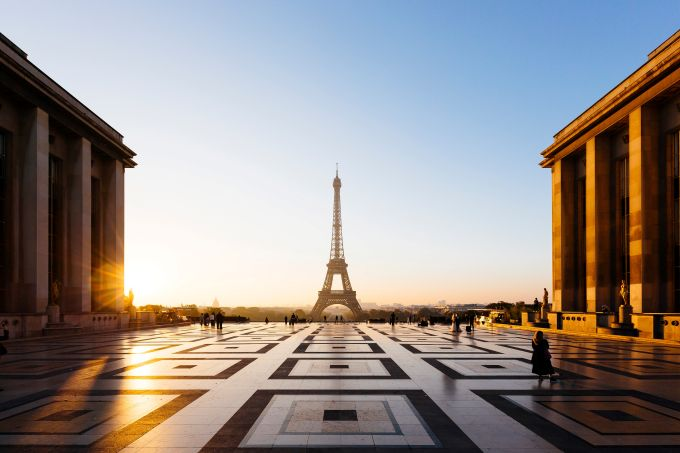

In [14]:
image_file = "test/image1.jpg"

display_image(image_file)

In [15]:
result = analyzing_image(image_file)
result

{'image_file': 'test/image1.jpg',
 'hate_severity': 0,
 'self_harm_severity': 0,
 'sexual_severity': 0,
 'violence_severity': 0}

Image file to classify: test/image2.jpg


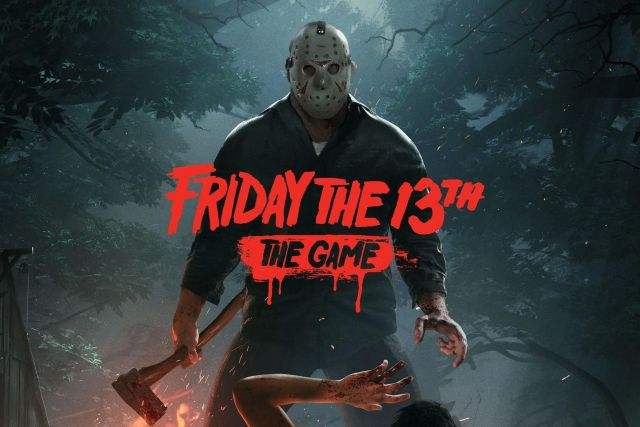

In [16]:
image_file = "test/image2.jpg"

display_image(image_file)

In [17]:
result = analyzing_image(image_file)
result

{'image_file': 'test/image2.jpg',
 'hate_severity': 0,
 'self_harm_severity': 0,
 'sexual_severity': 0,
 'violence_severity': 2}

## 4 Analyzing all the images files

In [18]:
df_infos = get_images_info(IMAGES_DIR)
df_infos

,image_file,size_in_bytes,image_width,image_height
0,defects_images/class1/class1 (1).jpg,30197,200,200
1,defects_images/class1/class1 (10).jpg,28580,200,200
2,defects_images/class1/class1 (100).jpg,29223,200,200
3,defects_images/class1/class1 (101).jpg,28916,200,200
4,defects_images/class1/class1 (102).jpg,30182,200,200
...,...,...,...,...
1607,defects_images/class6/class6 (95).jpg,20725,200,200
1608,defects_images/class6/class6 (96).jpg,21166,200,200
1609,defects_images/class6/class6 (97).jpg,21707,200,200
1610,defects_images/class6/class6 (98).jpg,22026,200,200


In [19]:
df_infos.describe()

,size_in_bytes,image_width,image_height
count,1612.000000,1612.0,1612.0
mean,27792.483871,200.0,200.0
std,6929.571337,0.0,0.0
min,16002.000000,200.0,200.0
25%,21065.000000,200.0,200.0
50%,28075.000000,200.0,200.0
75%,34063.000000,200.0,200.0
max,40095.000000,200.0,200.0


> All the images have the same resolution.

### Running Azure Content Safety on all the images

In [20]:
df = analyzing_all_images(IMAGES_DIR)

defects_images/class1 | Number of image files = 273
defects_images/class2 | Number of image files = 270
defects_images/class3 | Number of image files = 272
defects_images/class4 | Number of image files = 269
defects_images/class5 | Number of image files = 276
defects_images/class6 | Number of image files = 252

  1/1612 Processing image file defects_images/class1/class1 (1).jpg
  2/1612 Processing image file defects_images/class1/class1 (10).jpg
  3/1612 Processing image file defects_images/class1/class1 (100).jpg
  4/1612 Processing image file defects_images/class1/class1 (101).jpg
  5/1612 Processing image file defects_images/class1/class1 (102).jpg
  6/1612 Processing image file defects_images/class1/class1 (103).jpg
  7/1612 Processing image file defects_images/class1/class1 (104).jpg
  8/1612 Processing image file defects_images/class1/class1 (105).jpg
  9/1612 Processing image file defects_images/class1/class1 (106).jpg
 10/1612 Processing image file defects_images/class1/class1 

In [21]:
df

,image_file,hate_severity,self_harm_severity,sexual_severity,violence_severity
0,defects_images/class1/class1 (1).jpg,0,0,0,0
1,defects_images/class1/class1 (10).jpg,0,0,0,0
2,defects_images/class1/class1 (100).jpg,0,0,0,0
3,defects_images/class1/class1 (101).jpg,0,0,0,0
4,defects_images/class1/class1 (102).jpg,0,0,0,0
...,...,...,...,...,...
1607,defects_images/class6/class6 (95).jpg,0,0,0,0
1608,defects_images/class6/class6 (96).jpg,0,0,0,0
1609,defects_images/class6/class6 (97).jpg,0,0,0,0
1610,defects_images/class6/class6 (98).jpg,0,0,0,0


In [22]:
df.describe()

,hate_severity,self_harm_severity,sexual_severity,violence_severity
count,1612.0,1612.0,1612.0,1612.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


In [23]:
df['hate_severity'].value_counts(sort=True)

hate_severity
0    1612
Name: count, dtype: int64

In [24]:
df['self_harm_severity'].value_counts(sort=True)

self_harm_severity
0    1612
Name: count, dtype: int64

In [25]:
df['sexual_severity'].value_counts(sort=True)

sexual_severity
0    1612
Name: count, dtype: int64

In [26]:
df['violence_severity'].value_counts(sort=True)

violence_severity
0    1612
Name: count, dtype: int64

In [27]:
filtered_df = df[(df['hate_severity'] != 0) | (df['self_harm_severity'] != 0) |
                 (df['sexual_severity'] != 0) | (df['violence_severity'] != 0)]
filtered_df

,image_file,hate_severity,self_harm_severity,sexual_severity,violence_severity


In [28]:
files_to_delete = filtered_df['image_file'].tolist()

print("No issues with our images with Azure Content Safety" if len(files_to_delete) == 0 else "We do have some issues with our images")

No issues with our images with Azure Content Safety


> No issues with our images.

In [29]:
# If needed:

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"{file} has been deleted successfully.")
    except FileNotFoundError:
        print(f"{file} not found.")
    except Exception as e:
        print(f"Error deleting {file}: {e}")